In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
!pip install tensorboard -qq

In [3]:
import os
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.tensorboard import SummaryWriter

2024-09-08 08:50:10.388636: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-08 08:50:10.388733: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-08 08:50:10.548567: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# importing the dataset

In [4]:
#import dataset
ds=pd.read_csv('/kaggle/input/amazon-product-reviews/Reviews.csv')

In [5]:
ds.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# EDA

In [6]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [7]:
ds.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [8]:
ds=ds.dropna(how='any')

In [9]:
ds.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [10]:
#ds[ds['UserId']]

In [11]:
ds.drop(['ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Summary','Text'],axis=1,inplace=True)

In [12]:
ds['Time'].value_counts()

Time
1350345600    1143
1322179200    1088
1322438400    1070
1346889600    1018
1344211200     989
              ... 
1087084800       1
1088985600       1
1089763200       1
1098057600       1
1080432000       1
Name: count, Length: 3168, dtype: int64

In [13]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 568401 entries, 0 to 568453
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Id         568401 non-null  int64 
 1   ProductId  568401 non-null  object
 2   UserId     568401 non-null  object
 3   Score      568401 non-null  int64 
 4   Time       568401 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 26.0+ MB


# Encoding the features

In [14]:
object_encoders={}
columns=['ProductId','UserId']
for col in columns:
    le=LabelEncoder()
    ds[col]=le.fit_transform(ds[col])
    #storing the feature values and its encoded values
    object_encoders[col]=le

# lets make more features:
    * day of the week
    * month
    * time of the day(Hour)

In [15]:
#change the time stamp into datatime
ds['Time']=pd.to_datetime(ds['Time'],unit='s',utc=True)
ds['Time']=ds['Time'].dt.tz_convert('America/New_York')

In [16]:
ds.head()

,Id,ProductId,UserId,Score,Time
0,1,27619,188633,5,2011-04-26 20:00:00-04:00
1,2,72383,25104,1,2012-09-06 20:00:00-04:00
2,3,15267,210468,4,2008-08-17 20:00:00-04:00
3,4,19718,152622,2,2011-06-12 20:00:00-04:00
4,5,69007,57800,5,2012-10-20 20:00:00-04:00


In [17]:
ds.head()

,Id,ProductId,UserId,Score,Time
0,1,27619,188633,5,2011-04-26 20:00:00-04:00
1,2,72383,25104,1,2012-09-06 20:00:00-04:00
2,3,15267,210468,4,2008-08-17 20:00:00-04:00
3,4,19718,152622,2,2011-06-12 20:00:00-04:00
4,5,69007,57800,5,2012-10-20 20:00:00-04:00


In [18]:
#year
ds['year']=ds['Time'].dt.year
#month
ds['month']=ds['Time'].dt.month
#week
ds['day_of_week']=ds['Time'].dt.dayofweek
#hour
ds['hour']=ds['Time'].dt.time

In [19]:
ds.head()

,Id,ProductId,UserId,Score,Time,year,month,day_of_week,hour
0,1,27619,188633,5,2011-04-26 20:00:00-04:00,2011,4,1,20:00:00
1,2,72383,25104,1,2012-09-06 20:00:00-04:00,2012,9,3,20:00:00
2,3,15267,210468,4,2008-08-17 20:00:00-04:00,2008,8,6,20:00:00
3,4,19718,152622,2,2011-06-12 20:00:00-04:00,2011,6,6,20:00:00
4,5,69007,57800,5,2012-10-20 20:00:00-04:00,2012,10,5,20:00:00


In [20]:
ds.isnull().sum()

Id             0
ProductId      0
UserId         0
Score          0
Time           0
year           0
month          0
day_of_week    0
hour           0
dtype: int64

In [21]:
#droping the time column
clean_data=ds.drop(['Time'],axis=1)

In [22]:
#dropign the ID
clean_data.drop(['Id'],axis=1,inplace=True)

In [23]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 568401 entries, 0 to 568453
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ProductId    568401 non-null  int64 
 1   UserId       568401 non-null  int64 
 2   Score        568401 non-null  int64 
 3   year         568401 non-null  int32 
 4   month        568401 non-null  int32 
 5   day_of_week  568401 non-null  int32 
 6   hour         568401 non-null  object
dtypes: int32(3), int64(3), object(1)
memory usage: 28.2+ MB


In [24]:
#convert the hour feature into int
clean_data['hour']=clean_data['hour'].apply(lambda x:x.hour )

# lets add another feature:
        * Name of the feature is: recomended
        * the feature if gonna be boolean
        * we are gonna assign it True if its equal or greater than 3 : False other wise

In [25]:
clean_data['Recomended']=clean_data['Score']>=3

In [26]:
clean_data.columns

Index(['ProductId', 'UserId', 'Score', 'year', 'month', 'day_of_week', 'hour',
       'Recomended'],
      dtype='object')

## droping the 'Rate'---> Score

In [27]:
clean_data.drop(['Score'],axis=1,inplace=True)

# mapping features

In [28]:
clean_data['year'].value_counts()

year
2012    198050
2011    163536
2010     86088
2009     55403
2008     34144
2007     22333
2006      6686
2005      1344
2004       560
2003       133
2002        73
2000        32
2001        13
1999         6
Name: count, dtype: int64

In [29]:
def mapping_function_year(year):
    return year-1999

In [30]:
#clone=clean_data.copy()

In [31]:
clean_data['year']=clean_data['year'].apply(mapping_function_year)

# mapping hour

In [32]:
def mapping_function_hour(hour):
    return hour-19

In [33]:
clean_data['hour'].value_counts()

hour
20    382504
19    185897
Name: count, dtype: int64

In [34]:
clean_data['hour']=clean_data['hour'].apply(mapping_function_hour)

In [35]:
clean_data.head()

,ProductId,UserId,year,month,day_of_week,hour,Recomended
0,27619,188633,12,4,1,1,True
1,72383,25104,13,9,3,1,False
2,15267,210468,9,8,6,1,True
3,19718,152622,12,6,6,1,False
4,69007,57800,13,10,5,1,True


In [36]:
# scaler=MinMaxScaler()

# columns_to_scale=['year','month','hour','day_of_week']
# clean_data[columns_to_scale]=scaler.fit_transform(clean_data[columns_to_scale])

In [37]:
# lets change the boolean into number
clean_data['Recomended']=clean_data['Recomended'].astype(int)

# split into train and test

In [38]:
#split into train and test
train,test=train_test_split(
    clean_data,
    random_state=42,
    test_size=0.2,
    stratify=clean_data['Recomended']
)

# lets check for data distribution

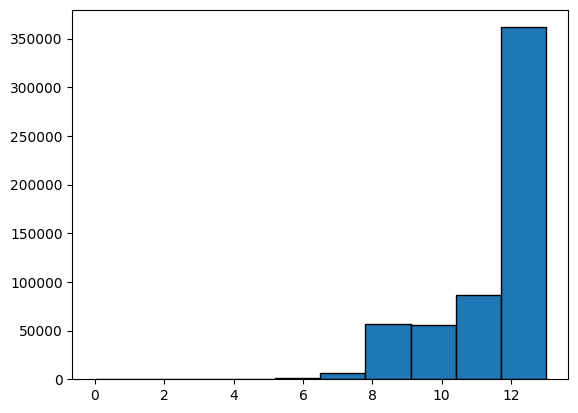

In [39]:
plt.hist(clean_data['year'],edgecolor='black')
plt.show()

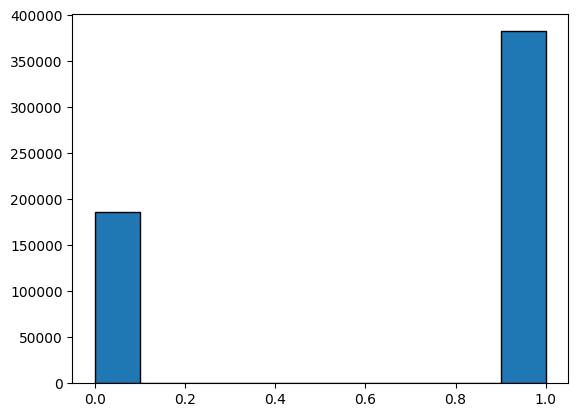

In [40]:
plt.hist(clean_data['hour'],edgecolor='black')
plt.show()

# turn them into torch dataset

In [41]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [42]:
p=torch.tensor(90,dtype=torch.long)

In [43]:
class Mydataset(Dataset):
    def __init__(self,data):
        super().__init__()
        self.data=data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        #element to extract
        item=self.data.iloc[idx]
        
        return {
            "product_id":torch.tensor([item['ProductId']],dtype=torch.long).to(device),
            "user_id":torch.tensor([item['UserId']],dtype=torch.long).to(device) ,
            "year":torch.tensor([item['year']],dtype=torch.long).to(device) ,
            "month":torch.tensor([item['month']],dtype=torch.long).to(device) ,
            "day_of_week":torch.tensor([item['day_of_week']],dtype=torch.long).to(device) ,
            "hour":torch.tensor([item['hour']],dtype=torch.long).to(device) ,
            "recomended":torch.tensor([item['Recomended']],dtype=torch.float).to(device)
        }

## loading the torch dataset format

In [44]:
#trainig dataset
train_dataset=Mydataset(train)
test_dataset=Mydataset(test)

In [45]:
print(train_dataset)
print(test_dataset)

# turning it into torch dataloader

In [46]:
#making the train dataloader
train_dataloader=DataLoader(
    dataset=train_dataset,
    batch_size=32
)

#making test dataloader
test_dataloader=DataLoader(
    dataset=test_dataset,
    batch_size=32
)

In [47]:
# acessing elements of the dataloader
for batch in train_dataloader:
    print(batch['product_id'].shape)
    print(batch['user_id'].shape)
    break

torch.Size([32, 1])
torch.Size([32, 1])


In [48]:
import shutil

In [49]:
#shutil.rmtree("/kaggle/working/tiny_recommendation")

In [50]:
!git clone https://github.com/nebyu08/tiny_recommendation.git

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Cloning into 'tiny_recommendation'...
remote: Enumerating objects: 234, done.
remote: Counting objects: 100% (234/234), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 234 (delta 115), reused 192 (delta 77), pack-reused 0 (from 0)
Receiving objects: 100% (234/234), 2.55 MiB | 8.12 MiB/s, done.
Resolving deltas: 100% (115/115), done.


# model package importing

In [51]:
#import sys
#sys.path.append('C:/Users/nebiy/Documents/recommendation_system/tiny_recommendation/jupyter_notes/main.py')
from tiny_recommendation.main import WideDeep,WD_Config

In [52]:
config=WD_Config()
config.num_product=clean_data['ProductId'].nunique()
config.num_users=clean_data['UserId'].nunique() 
config.num_year=clean_data["year"].nunique()
config.num_time_day=clean_data["hour"].nunique()
config.num_month=clean_data['month'].nunique()+1   #since in this column it start from 1
config.num_day_week=clean_data["day_of_week"].nunique()
config.embedding_dim=100

In [53]:
print(config)

WD_Config(num_product=74257, num_users=256042, num_day_week=7, num_month=13, num_time_day=2, num_feature=6, embedding_dim=100, num_year=14)


In [54]:
model=WideDeep(config)

# setup the config of the model

In [55]:
clean_data["day_of_week"].value_counts()

day_of_week
2    87051
1    85986
0    85850
6    85360
3    79679
5    72791
4    71684
Name: count, dtype: int64

In [56]:
# config.num_product=clean_data['ProductId'].nunique()+1
# config.num_users=clean_data['UserId'].nunique() +1
# config.num_year=clean_data["year"].nunique()+1
# config.num_time_day=clean_data["hour"].nunique()+1
# config.num_month=clean_data['month'].nunique()+1
# config.num_day_week=clean_data["day_of_week"].nunique()+1
# config.embedding_dim=100

In [57]:
model=model.to(device)

In [58]:
# for name,param in model.named_parameters():
#     if(param.requires_grad):
#         print(name)

In [59]:
# for name,param in model.named_parameters():
#     if not(param.requires_grad):
#         print(name)

In [60]:
optim=torch.optim.AdamW(model.parameters(),lr=0.01,weight_decay=0.01)  #the deep component
loss_fn=torch.nn.BCEWithLogitsLoss() 

# lets debug some stuff with data and model

In [61]:
# lets access 10 elements from one batch
for batch in train_dataloader:
    product_id=batch["product_id"]
    user_id=batch["user_id"]
    year=batch["year"]
    month=batch["month"]
    day_of_week=batch["day_of_week"]
    hour=batch["hour"]
    recomended=batch["recomended"]
    
    print(product_id.size(0))
    print(user_id.shape)
    print(year.shape)
    print(recomended.shape)
    print(month.shape)
    print(year.shape)
    print(day_of_week.shape)

    break

32
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])


In [62]:
print(device)

cuda


In [63]:
model=model.to(device)

# train my model

In [64]:
# extraxt one batch 
for batch in train_dataloader:
    one_batch=batch
    break

In [65]:
# reco=batch['recomended']
# print(reco)

In [66]:
writer=SummaryWriter('runs/wide_deep_model')

In [67]:
batches=[]
for idx,batch in enumerate(train_dataloader):
    if(idx<10):
        batches.append(batch)
    break

In [68]:
# devices={param.is_cuda for param in model.parameters()}

In [69]:
#print(devices)

In [70]:
# for idx,items in enumerate(train_dataloader):
#     print(items['product_id'].is_cuda)
#     print(items['user_id'].is_cuda)
#     print(items['year'].is_cuda)
#     print(items['month'].is_cuda)
#     print(items['day_of_week'].is_cuda)
#     print(items['recomended'].is_cuda)
#     break

In [71]:
#lets start the training
n_epoch=1000
for epoch in range(n_epoch):
    for batch in batches:
        #getting the shape right
        product_id=batch['product_id']
        user_id=batch['user_id']
        year=batch['year']
        month=batch['month']
        day_of_week=batch['day_of_week']
        hour=batch['hour']
        recomended=batch['recomended']
    
        #changing the value of the recomended
        recomended=recomended.float()
        
        #feed forward model
        model_pred=model(
            product_id,
            user_id,
            year,
            month,
            day_of_week,
            hour
        )
    
        #print(f"loss at {epoch} epoch : is {model_pred} ")
    
        #calculate the loss
        loss=loss_fn(model_pred,recomended)
        
        #zero grad
        optim.zero_grad()
        loss.backward()
    
        #lets clip the gradient of the module
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        
        optim.step() #update the gradient 

        #lets see the weights
        for name,param in model.named_parameters():
            writer.add_histogram(name,param,epoch)

        #lets see the gradient norm
        total_norm=0
        for param in model.parameters():
            param_norm=param.grad.data.norm(2)
            total_norm+=param_norm.item()**2
        
        total_norm=total_norm**0.5
        writer.add_scalar('gradient norm',total_norm,epoch)


        #lets recoord the loss
        writer.add_scalar('loss/train',loss.item(),epoch)
        
        
        #display the loss every 5 epoch
    if(epoch%100==0):
        print(f"the loss is {loss.item()}")

#lets close the tenosrboard
writer.close()

the loss is 84985.953125
the loss is 0.0
the loss is 0.0
the loss is 19.563232421875
the loss is 0.0
the loss is 0.0
the loss is 0.0
the loss is 0.0
the loss is 0.0
the loss is 0.0


In [72]:
%load_ext tensorboard

%tensorboard -logdir runs/wide_deep_model

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2024-09-08 09:07:02.197152: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-08 09:07:02.197245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-08 09:07:02.198742: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--reuse_port BOOL] [--load_fast {false,auto,true}]
                   [--extra_data_server_flags EXTRA_DATA_SERVER_FLAGS]
           